In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import xgboost as xgb

from sklearn.preprocessing import PowerTransformer


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [9]:
df = pd.read_csv("EDAed_df.csv")

df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])

In [10]:
df.shape

(2000000, 26)

In [11]:
df.isnull().sum()

Age                            0
Gender                         0
Annual Income                  0
Marital Status                 0
Number of Dependents           0
Education Level                0
Occupation                     0
Health Score                   0
Location                       0
Policy Type                    0
Previous Claims                0
Vehicle Age                    0
Credit Score                   0
Insurance Duration             0
Policy Start Date              0
Customer Feedback              0
Smoking Status                 0
Exercise Frequency             0
Property Type                  0
Premium Amount            800000
Health Conscious Level         0
Money Per Head                 0
Money Handling Level           0
Growth                         0
Growth1                        0
Determinstic                   0
dtype: int64

In [12]:
train = df.iloc[:1200000, :]
train.shape

(1200000, 26)

In [13]:
test = df.iloc[1200000:, :]
test.shape

(800000, 26)

In [14]:
test.head(3)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Health Conscious Level,Money Per Head,Money Handling Level,Growth,Growth1,Determinstic
1200000,28.0,Female,2310.0,Single,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,2.0,19.0,493.0,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House,NaN,2,577.5,1138830.0,4620.0,1155.000000,82.500000
1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,1.0,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment,NaN,1,63015.5,46883532.0,378093.0,42010.333333,4065.516129
1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,1.0,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo,NaN,3,17092.0,13998348.0,68368.0,4273.000000,363.659574


#
---
#

# Adding Dates columns

In [15]:
df["Policy Start Date - Day"] = df["Policy Start Date"].dt.day
df["Policy Start Date - Month"] = df["Policy Start Date"].dt.month
df["Policy Start Date - Year"] = df["Policy Start Date"].dt.year

In [16]:
df["Policy Start Date - Quarter"] = df["Policy Start Date"].dt.year.astype(str) + " Q" + df["Policy Start Date"].dt.quarter.astype(str)

In [17]:
df["Sin_Date"] = np.sin(2 * np.pi * df["Policy Start Date"].astype('int64'))
df["Cos_Date"] = np.cos(2 * np.pi * df["Policy Start Date"].astype('int64'))

In [18]:
df.head(3)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Health Conscious Level,Money Per Head,Money Handling Level,Growth,Growth1,Determinstic,Policy Start Date - Day,Policy Start Date - Month,Policy Start Date - Year,Policy Start Date - Quarter,Sin_Date,Cos_Date
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0,4,10049.000000,3738228.0,20098.0,5024.500000,528.894737,23,12,2023,2023 Q4,-0.975344,-0.220691
1,39.0,Female,31678.0,Divorced,3.0,Master's,Self-Employed,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0,2,10559.333333,21984532.0,95034.0,10559.333333,812.256410,12,6,2023,2023 Q2,-0.998725,0.050489
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,555.0,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,4,8534.000000,14209110.0,25602.0,25602.000000,1113.130435,30,9,2023,2023 Q3,-0.994867,0.101192


#
---
#

In [19]:
data = df.copy()

#
---
#

In [20]:
df.drop(columns="Policy Start Date", inplace=True)

In [22]:
df.head(3)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Health Conscious Level,Money Per Head,Money Handling Level,Growth,Growth1,Determinstic,Policy Start Date - Day,Policy Start Date - Month,Policy Start Date - Year,Policy Start Date - Quarter,Sin_Date,Cos_Date
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,4,10049.000000,3738228.0,20098.0,5024.500000,528.894737,23,12,2023,2023 Q4,-0.975344,-0.220691
1,39.0,Female,31678.0,Divorced,3.0,Master's,Self-Employed,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,2,10559.333333,21984532.0,95034.0,10559.333333,812.256410,12,6,2023,2023 Q2,-0.998725,0.050489
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,555.0,3.0,Good,Yes,Weekly,House,567.0,4,8534.000000,14209110.0,25602.0,25602.000000,1113.130435,30,9,2023,2023 Q3,-0.994867,0.101192


In [23]:
df[["Policy Start Date - Day", "Policy Start Date - Month", "Policy Start Date - Year"]] = df[["Policy Start Date - Day", "Policy Start Date - Month", "Policy Start Date - Year"]].astype("O")

In [24]:
def show_nulls(df):
    nulls = []
    nuniques = []
    uniques = []
    types = []
    
    for i in df.columns:
        nulls.append(df[i].isnull().sum())
        nuniques.append(df[i].nunique())
        uniques.append(df[i].unique())
        types.append(df[i].dtype)
    
    
    return pd.DataFrame(
        {
            "Column" : df.columns,
            "Data Type" : types,
            "Nulls" : nulls,
            "No. of Uniques" : nuniques,
            "Uniques" : uniques
        }
    ).sort_values(by="Nulls", ascending=False)

In [25]:
show_nulls(df)

,Column,Data Type,Nulls,No. of Uniques,Uniques
18,Premium Amount,float64,800000,4794,"[2869.0, 1483.0, 567.0, 765.0, 2022.0, 3202.0,..."
1,Gender,object,0,2,"[Female, Male]"
0,Age,float64,0,47,"[19.0, 39.0, 23.0, 21.0, 29.0, 41.0, 48.0, 44...."
3,Marital Status,object,0,3,"[Married, Divorced, Single]"
4,Number of Dependents,float64,0,5,"[1.0, 3.0, 2.0, 0.0, 4.0]"
5,Education Level,object,0,4,"[Bachelor's, Master's, High School, PhD]"
2,Annual Income,float64,0,97952,"[10049.0, 31678.0, 25602.0, 141855.0, 39651.0,..."
7,Health Score,float64,0,934000,"[22.59876067181393, 15.569730989408043, 47.177..."
8,Location,object,0,3,"[Urban, Rural, Suburban]"
9,Policy Type,object,0,3,"[Premium, Comprehensive, Basic]"


#
---
#

In [26]:
def do_magic(target_column, *columns: list):
    for i in columns:
        df[f"{i}_MIN_{target_column}"] = df.groupby(by=i)[target_column].transform("min")
        df[f"{i}_MEAN_{target_column}"] = df.groupby(by=i)[target_column].transform("mean")
        df[f"{i}_MEDIAN_{target_column}"] = df.groupby(by=i)[target_column].transform("median")
        df[f"{i}_STD_{target_column}"] = df.groupby(by=i)[target_column].transform("std")
        df[f"{i}_MAX_{target_column}"] = df.groupby(by=i)[target_column].transform("max")

In [27]:
do_magic("Premium Amount", "Number of Dependents", "Occupation", "Education Level", "Previous Claims", "Insurance Duration")

In [28]:
df

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Health Conscious Level,Money Per Head,Money Handling Level,Growth,Growth1,Determinstic,Policy Start Date - Day,Policy Start Date - Month,Policy Start Date - Year,Policy Start Date - Quarter,Sin_Date,Cos_Date,Number of Dependents_MIN_Premium Amount,Number of Dependents_MEAN_Premium Amount,Number of Dependents_MEDIAN_Premium Amount,Number of Dependents_STD_Premium Amount,Number of Dependents_MAX_Premium Amount,Occupation_MIN_Premium Amount,Occupation_MEAN_Premium Amount,Occupation_MEDIAN_Premium Amount,Occupation_STD_Premium Amount,Occupation_MAX_Premium Amount,Education Level_MIN_Premium Amount,Education Level_MEAN_Premium Amount,Education Level_MEDIAN_Premium Amount,Education Level_STD_Premium Amount,Education Level_MAX_Premium Amount,Previous Claims_MIN_Premium Amount,Previous Claims_MEAN_Premium Amount,Previous Claims_MEDIAN_Premium Amount,Previous Claims_STD_Premium Amount,Previous Claims_MAX_Premium Amount,Insurance Duration_MIN_Premium Amount,Insurance Duration_MEAN_Premium Amount,Insurance Duration_MEDIAN_Premium Amount,Insurance Duration_STD_Premium Amount,Insurance Duration_MAX_Premium Amount
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,4,10049.000000,3738228.0,20098.0,5024.500000,528.894737,23,12,2023,2023 Q4,-0.975344,-0.220691,20.0,1107.625281,878.0,866.838892,4994.0,20.0,1099.847641,870.0,864.000609,4999.0,20.0,1102.698438,873.0,864.866296,4988.0,20.0,1157.177084,912.0,898.578219,4991.0,20.0,1100.812035,872.0,859.965806,4996.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,Self-Employed,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,2,10559.333333,21984532.0,95034.0,10559.333333,812.256410,12,6,2023,2023 Q2,-0.998725,0.050489,20.0,1102.153646,874.0,863.643171,4997.0,20.0,1099.847641,870.0,864.000609,4999.0,20.0,1102.113989,871.0,866.235322,4997.0,20.0,1083.665634,853.0,856.283142,4997.0,20.0,1106.883166,878.0,863.675409,4997.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,555.0,3.0,Good,Yes,Weekly,House,567.0,4,8534.000000,14209110.0,25602.0,25602.000000,1113.130435,30,9,2023,2023 Q3,-0.994867,0.101192,20.0,1102.153646,874.0,863.643171,4997.0,20.0,1099.847641,870.0,864.000609,4999.0,20.0,1104.787490,876.0,865.951488,4999.0,20.0,1083.665634,853.0,856.283142,4997.0,20.0,1101.733536,872.0,865.791213,4997.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,Self-Employed,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,3,70927.500000,52060785.0,283710.0,70927.500000,6755.000000,12,6,2024,2024 Q2,0.111402,0.993775,20.0,1107.670467,874.0,867.079610,4997.0,20.0,1099.847641,870.0,864.000609,4999.0,20.0,1102.698438,873.0,864.866296,4988.0,20.0,1083.665634,853.0,856.283142,4997.0,20.0,1097.042977,861.0,865.431191,4988.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,2022.0,3,39651.000000,23711298.0,79302.0,19825.500000,1888.142857,1,12,2021,2021 Q4,-0.996246,0.086565,20.0,1107.625281,878.0,866.838892,4994.0,20.0,1099.847641,870.0,864.000609,4999.0,20.0,1102.698438,873.0,864.866296,4988.0,20.0,1080.669491,855.0,847.585613,4999.0,20.0,1104.723079,872.0,866.377508,4991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,50.0,Female,38782.0,Married,1.0,Bachelor's,Employed,14.498639,Rural,Premium,1.0,8.0,309.0,2.0,Average,Yes,Daily,Condo,NaN,4,38782.000000,11983638.0,77564.0,19391.000000,775.640000,9,7,2021,2021 Q3,0.645845,-0.763468,20.0,

#
---
#

In [29]:
def return_splits(ddf, feature_name, target_name):
    return [ddf[ddf[feature_name] == i][target_name] for i in ddf[feature_name].unique()]

def give_stats_analysis(df, target_column_name):
    ddf = df.copy()
    ddf = ddf.dropna()

    features = []
    tests = []
    stats = []
    pvals = []
    verdict = []
    count = 0

    target = ddf[target_column_name]
    for i in ddf.columns:
        features.append(i)
        feature = ddf[i]
        
        if (feature.dtype == "O" and (target.dtype == "float" or target.dtype == "int")) or (target.dtype == "O" and (feature.dtype == "float" or feature.dtype == "int")):
            stat, pval, *_ = kruskal(*return_splits(ddf, feature.name, target.name))
            tests.append("Kruskal-Wallis")
            stats.append(stat)
            pvals.append(pval)
            
        
        elif (feature.dtype == "float" or feature.dtype == "int") and (target.dtype == "float" or target.dtype == "int"):
            stat, pval, *_ = spearmanr(feature, target)
            tests.append("SpearmanR")
            stats.append(stat)
            pvals.append(pval)

        elif feature.dtype == "O" and target.dtype == "O":
            stat, pval, *_ = chi2_contingency(pd.crosstab(feature, target))
            tests.append("Chi-Square")
            stats.append(stat)
            pvals.append(pval)
        
        else:
            tests.append(np.nan)
            stats.append(np.nan)
            pvals.append(np.nan)
        
        if pval <= 0.025:
            verdict.append("There is Relationship")
        else:
            verdict.append("There is NO Relationship")

        print(f"{feature.name} ■■■ {target_column_name}".ljust(100, "-")+"✅")
    
    return pd.DataFrame({
        "Feature" : features,
        "Target" : [target_column_name]*ddf.shape[1],
        "Statistic Test" : tests,
        "Test Statistic" : stats,
        "P-Value" : pvals,
        "Verdict" : verdict
    }).sort_values(by="P-Value")

# H0 :- There is ***No Relationship*** among the given two columns
# H1 :- There is ***Relationship*** among the given two columns

### ***Health-related indicators***
- [x] Health Score
- [x] Smoking Status
- [x] Exercise Frequency
### ***Demographic information***
- [x] Age
- [x] Gender
- [x] Marital Status
- [x] Number of Dependents
- [x] Occupation
### ***Policy details***
- [x] Policy Type
- [x] Policy Start Date
- [x] Insurance Duration
### ***Financial factors***
- [x] Annual Income
- [x] Credit Score.
### ***Premium calculation***
- [x] Premium Amount

In [30]:
stats_result = give_stats_analysis(df.iloc[:1200000, :], "Premium Amount")
stats_result

Age ■■■ Premium Amount------------------------------------------------------------------------------✅
Gender ■■■ Premium Amount---------------------------------------------------------------------------✅
Annual Income ■■■ Premium Amount--------------------------------------------------------------------✅
Marital Status ■■■ Premium Amount-------------------------------------------------------------------✅
Number of Dependents ■■■ Premium Amount-------------------------------------------------------------✅
Education Level ■■■ Premium Amount------------------------------------------------------------------✅
Occupation ■■■ Premium Amount-----------------------------------------------------------------------✅
Health Score ■■■ Premium Amount---------------------------------------------------------------------✅
Location ■■■ Premium Amount-------------------------------------------------------------------------✅
Policy Type ■■■ Premium Amount----------------------------------------------------

,Feature,Target,Statistic Test,Test Statistic,P-Value,Verdict
2,Annual Income,Premium Amount,SpearmanR,-0.060743,0.000000e+00,There is Relationship
12,Credit Score,Premium Amount,SpearmanR,-0.037141,0.000000e+00,There is Relationship
24,Determinstic,Premium Amount,SpearmanR,-0.055946,0.000000e+00,There is Relationship
23,Growth1,Premium Amount,SpearmanR,-0.052737,0.000000e+00,There is Relationship
20,Money Per Head,Premium Amount,SpearmanR,-0.052062,0.000000e+00,There is Relationship
21,Money Handling Level,Premium Amount,SpearmanR,-0.070907,0.000000e+00,There is Relationship
22,Growth,Premium Amount,SpearmanR,-0.054155,0.000000e+00,There is Relationship
18,Premium Amount,Premium Amount,SpearmanR,1.000000,0.000000e+00,There is Relationship
48,Previous Claims_MEDIAN_Premium Amount,Premium Amount,SpearmanR,0.032126,1.918797e-271,There is Relationship
47,Previous Claims_MEAN_Premium Amount,Premium Amount,SpearmanR,0.031064,6.364897e-254,There is Relationship


# <ins>Key Premium as per Reseach Papers and as per dataset.</ins>
### `Strikeoff features are said by research and dataset too. But unstrike ones are not impactful to determine premium amount as per dataset but as per research it should be. We need to find why like so in these features`

- ### ~~Age~~
- ### Gender
- ### ~~Health Score~~
- ### Smoking Status
- ### Exercise Frequency
- ### ~~Occupation~~
- ### Policy Type
- ### ~~Previous Claims~~
- ### ~~Annual Income~~
- ### Insurance Duration
- ### ~~Credit Score~~

#
---
#

In [31]:
cols = ["Gender", "Smoking Status", "Exercise Frequency", "Policy Type", "Insurance Duration"]

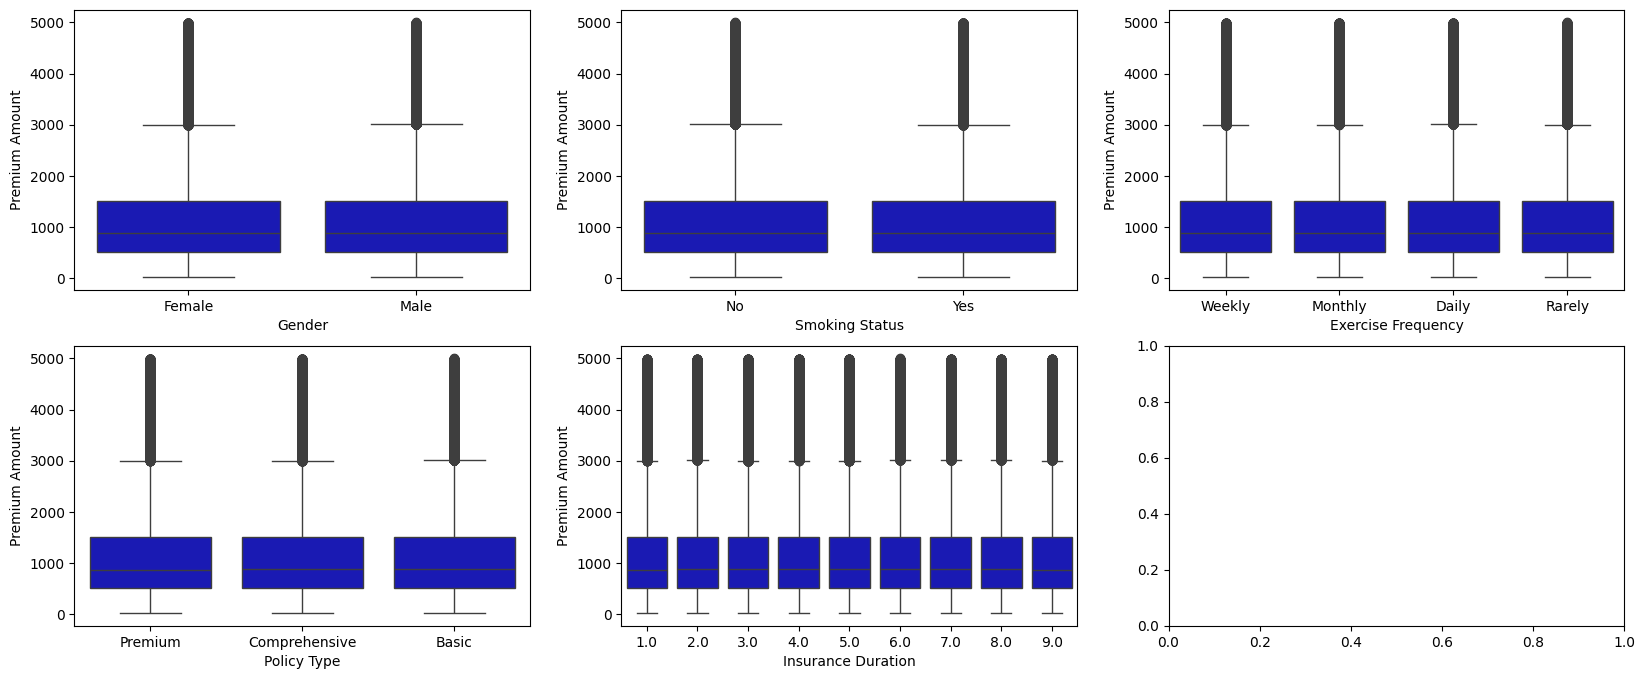

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
for col, ax in zip(cols, axs.flatten()):
    sns.boxplot(y=df["Premium Amount"], x=df[col], color="mediumblue", ax=ax)

In [33]:
useless_columns = stats_result[stats_result["P-Value"] >= 0.05]["Feature"]
useless_columns

42        Education Level_MEAN_Premium Amount
43      Education Level_MEDIAN_Premium Amount
8                                    Location
5                             Education Level
30                                   Cos_Date
11                                Vehicle Age
9                                 Policy Type
35    Number of Dependents_MAX_Premium Amount
45         Education Level_MAX_Premium Amount
17                              Property Type
16                         Exercise Frequency
15                             Smoking Status
44         Education Level_STD_Premium Amount
25                    Policy Start Date - Day
1                                      Gender
29                                   Sin_Date
13                         Insurance Duration
Name: Feature, dtype: object

In [34]:
meaningless_df = df[useless_columns]
meaningless_df.head(3)

,Education Level_MEAN_Premium Amount,Education Level_MEDIAN_Premium Amount,Location,Education Level,Cos_Date,Vehicle Age,Policy Type,Number of Dependents_MAX_Premium Amount,Education Level_MAX_Premium Amount,Property Type,Exercise Frequency,Smoking Status,Education Level_STD_Premium Amount,Policy Start Date - Day,Gender,Sin_Date,Insurance Duration
0,1102.698438,873.0,Urban,Bachelor's,-0.220691,17.0,Premium,4994.0,4988.0,House,Weekly,No,864.866296,23,Female,-0.975344,5.0
1,1102.113989,871.0,Rural,Master's,0.050489,12.0,Comprehensive,4997.0,4997.0,House,Monthly,Yes,866.235322,12,Female,-0.998725,2.0
2,1104.787490,876.0,Suburban,High School,0.101192,14.0,Premium,4997.0,4999.0,House,Weekly,Yes,865.951488,30,Male,-0.994867,3.0


In [35]:
df = df[stats_result[stats_result["P-Value"] < 0.05]["Feature"]]
df.head(3)

,Annual Income,Credit Score,Determinstic,Growth1,Money Per Head,Money Handling Level,Growth,Premium Amount,Previous Claims_MEDIAN_Premium Amount,Previous Claims_MEAN_Premium Amount,Previous Claims,Previous Claims_STD_Premium Amount,Previous Claims_MAX_Premium Amount,Policy Start Date - Year,Policy Start Date - Quarter,Health Score,Policy Start Date - Month,Number of Dependents_MEAN_Premium Amount,Health Conscious Level,Number of Dependents_MEDIAN_Premium Amount,Insurance Duration_MEAN_Premium Amount,Insurance Duration_MEDIAN_Premium Amount,Customer Feedback,Number of Dependents_STD_Premium Amount,Occupation_MEDIAN_Premium Amount,Occupation_MEAN_Premium Amount,Occupation_MAX_Premium Amount,Occupation,Previous Claims_MIN_Premium Amount,Insurance Duration_MAX_Premium Amount,Age,Insurance Duration_STD_Premium Amount,Number of Dependents,Marital Status,Occupation_STD_Premium Amount
0,10049.0,372.0,528.894737,5024.500000,10049.000000,3738228.0,20098.0,2869.0,912.0,1157.177084,2.0,898.578219,4991.0,2023,2023 Q4,22.598761,12,1107.625281,4,878.0,1100.812035,872.0,Poor,866.838892,870.0,1099.847641,4999.0,Self-Employed,20.0,4996.0,19.0,859.965806,1.0,Married,864.000609
1,31678.0,694.0,812.256410,10559.333333,10559.333333,21984532.0,95034.0,1483.0,853.0,1083.665634,1.0,856.283142,4997.0,2023,2023 Q2,15.569731,6,1102.153646,2,874.0,1106.883166,878.0,Average,863.643171,870.0,1099.847641,4999.0,Self-Employed,20.0,4997.0,39.0,863.675409,3.0,Divorced,864.000609
2,25602.0,555.0,1113.130435,25602.000000,8534.000000,14209110.0,25602.0,567.0,853.0,1083.665634,1.0,856.283142,4997.0,2023,2023 Q3,47.177549,9,1102.153646,4,874.0,1101.733536,872.0,Good,863.643171,870.0,1099.847641,4999.0,Self-Employed,20.0,4997.0,23.0,865.791213,3.0,Divorced,864.000609


# Compressing Meaningless DF's information in a component using PCA

In [36]:
meaningless_df.head(3)

,Education Level_MEAN_Premium Amount,Education Level_MEDIAN_Premium Amount,Location,Education Level,Cos_Date,Vehicle Age,Policy Type,Number of Dependents_MAX_Premium Amount,Education Level_MAX_Premium Amount,Property Type,Exercise Frequency,Smoking Status,Education Level_STD_Premium Amount,Policy Start Date - Day,Gender,Sin_Date,Insurance Duration
0,1102.698438,873.0,Urban,Bachelor's,-0.220691,17.0,Premium,4994.0,4988.0,House,Weekly,No,864.866296,23,Female,-0.975344,5.0
1,1102.113989,871.0,Rural,Master's,0.050489,12.0,Comprehensive,4997.0,4997.0,House,Monthly,Yes,866.235322,12,Female,-0.998725,2.0
2,1104.787490,876.0,Suburban,High School,0.101192,14.0,Premium,4997.0,4999.0,House,Weekly,Yes,865.951488,30,Male,-0.994867,3.0


## Endoing Columns

In [37]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

###
---
###

In [38]:
meaningless_df["Location"].unique()

array(['Urban', 'Rural', 'Suburban'], dtype=object)

In [39]:
a = OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']])

b = pd.DataFrame({"ENCODED_Location" : a.fit_transform(meaningless_df[["Location"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Location", inplace=True)

###
---
###

In [40]:
meaningless_df["Education Level"].unique()

array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [41]:
a = OrdinalEncoder(categories=[['High School', "Bachelor's", "Master's", 'PhD']])

b = pd.DataFrame({"ENCODED_Education Level" : a.fit_transform(meaningless_df[["Education Level"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Education Level", inplace=True)

###
---
###

In [42]:
meaningless_df["Policy Type"].unique()

array(['Premium', 'Comprehensive', 'Basic'], dtype=object)

In [43]:
a = OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']])

b = pd.DataFrame({"ENCODED_Policy Type" : a.fit_transform(meaningless_df[["Policy Type"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Policy Type", inplace=True)

###
---
###

In [44]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(meaningless_df[["Property Type"]]),
        columns=a.get_feature_names_out()
    )

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Property Type", inplace=True)

###
---
###

In [45]:
meaningless_df["Exercise Frequency"].unique()

array(['Weekly', 'Monthly', 'Daily', 'Rarely'], dtype=object)

In [46]:
a = OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])

b = pd.DataFrame({"ENCODED_Exercise Frequency" : a.fit_transform(meaningless_df[["Exercise Frequency"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Exercise Frequency", inplace=True)

###
---
###

In [47]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(meaningless_df[["Smoking Status"]]),
        columns=a.get_feature_names_out()
    )

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Smoking Status", inplace=True)

###
---
###

In [48]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(meaningless_df[["Gender"]]),
        columns=a.get_feature_names_out()
    )

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Gender", inplace=True)

###
---
###

In [49]:
meaningless_df["Policy Start Date - Day"] = meaningless_df["Policy Start Date - Day"].astype(int)

#
---
#

In [51]:
meaningless_df.head(3)

,Education Level_MEAN_Premium Amount,Education Level_MEDIAN_Premium Amount,Cos_Date,Vehicle Age,Number of Dependents_MAX_Premium Amount,Education Level_MAX_Premium Amount,Education Level_STD_Premium Amount,Policy Start Date - Day,Sin_Date,Insurance Duration,ENCODED_Location,ENCODED_Education Level,ENCODED_Policy Type,Property Type_Condo,Property Type_House,ENCODED_Exercise Frequency,Smoking Status_Yes,Gender_Male
0,1102.698438,873.0,-0.220691,17.0,4994.0,4988.0,864.866296,23,-0.975344,5.0,2.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0
1,1102.113989,871.0,0.050489,12.0,4997.0,4997.0,866.235322,12,-0.998725,2.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0
2,1104.787490,876.0,0.101192,14.0,4997.0,4999.0,865.951488,30,-0.994867,3.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,1.0


In [52]:
meaningless_df.dtypes

Education Level_MEAN_Premium Amount        float64
Education Level_MEDIAN_Premium Amount      float64
Cos_Date                                   float64
Vehicle Age                                float64
Number of Dependents_MAX_Premium Amount    float64
Education Level_MAX_Premium Amount         float64
Education Level_STD_Premium Amount         float64
Policy Start Date - Day                      int64
Sin_Date                                   float64
Insurance Duration                         float64
ENCODED_Location                           float64
ENCODED_Education Level                    float64
ENCODED_Policy Type                        float64
Property Type_Condo                        float64
Property Type_House                        float64
ENCODED_Exercise Frequency                 float64
Smoking Status_Yes                         float64
Gender_Male                                float64
dtype: object

###
---
###

# Doing PCA on this `meaningless_df`

In [53]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(meaningless_df), columns=['PC1_Meaningless_df', "PC2_Meaningless_df", "PC3_Meaningless_df"])
pca_df

,PC1_Meaningless_df,PC2_Meaningless_df,PC3_Meaningless_df
0,7.301867,7.436188,-4.590737
1,-3.711055,2.421474,2.570461
2,14.289578,4.392205,6.913333
3,-3.714732,-9.556627,-4.649131
4,-14.706402,-1.544916,-4.634879
...,...,...,...
1999995,-6.705961,-1.554958,-4.628942
1999996,12.276510,-9.591336,2.545394
1999997,14.284954,0.412700,2.580199
1999998,-6.707815,7.431978,2.586981


In [55]:
pca.explained_variance_ratio_

array([0.46366669, 0.19926157, 0.14128827])

###
---
###

# Combining 2 PCs of Meaningless_columns to the df

In [56]:
df = pd.concat([df, pca_df.iloc[:, :2]], axis=1)

In [57]:
df.head()

,Annual Income,Credit Score,Determinstic,Growth1,Money Per Head,Money Handling Level,Growth,Premium Amount,Previous Claims_MEDIAN_Premium Amount,Previous Claims_MEAN_Premium Amount,Previous Claims,Previous Claims_STD_Premium Amount,Previous Claims_MAX_Premium Amount,Policy Start Date - Year,Policy Start Date - Quarter,Health Score,Policy Start Date - Month,Number of Dependents_MEAN_Premium Amount,Health Conscious Level,Number of Dependents_MEDIAN_Premium Amount,Insurance Duration_MEAN_Premium Amount,Insurance Duration_MEDIAN_Premium Amount,Customer Feedback,Number of Dependents_STD_Premium Amount,Occupation_MEDIAN_Premium Amount,Occupation_MEAN_Premium Amount,Occupation_MAX_Premium Amount,Occupation,Previous Claims_MIN_Premium Amount,Insurance Duration_MAX_Premium Amount,Age,Insurance Duration_STD_Premium Amount,Number of Dependents,Marital Status,Occupation_STD_Premium Amount,PC1_Meaningless_df,PC2_Meaningless_df
0,10049.0,372.0,528.894737,5024.500000,10049.000000,3738228.0,20098.0,2869.0,912.0,1157.177084,2.0,898.578219,4991.0,2023,2023 Q4,22.598761,12,1107.625281,4,878.0,1100.812035,872.0,Poor,866.838892,870.0,1099.847641,4999.0,Self-Employed,20.0,4996.0,19.0,859.965806,1.0,Married,864.000609,7.301867,7.436188
1,31678.0,694.0,812.256410,10559.333333,10559.333333,21984532.0,95034.0,1483.0,853.0,1083.665634,1.0,856.283142,4997.0,2023,2023 Q2,15.569731,6,1102.153646,2,874.0,1106.883166,878.0,Average,863.643171,870.0,1099.847641,4999.0,Self-Employed,20.0,4997.0,39.0,863.675409,3.0,Divorced,864.000609,-3.711055,2.421474
2,25602.0,555.0,1113.130435,25602.000000,8534.000000,14209110.0,25602.0,567.0,853.0,1083.665634,1.0,856.283142,4997.0,2023,2023 Q3,47.177549,9,1102.153646,4,874.0,1101.733536,872.0,Good,863.643171,870.0,1099.847641,4999.0,Self-Employed,20.0,4997.0,23.0,865.791213,3.0,Divorced,864.000609,14.289578,4.392205
3,141855.0,367.0,6755.000000,70927.500000,70927.500000,52060785.0,283710.0,765.0,853.0,1083.665634,1.0,856.283142,4997.0,2024,2024 Q2,10.938144,6,1107.670467,3,874.0,1097.042977,861.0,Poor,867.079610,870.0,1099.847641,4999.0,Self-Employed,20.0,4988.0,21.0,865.431191,2.0,Married,864.000609,-3.714732,-9.556627
4,39651.0,598.0,1888.142857,19825.500000,39651.000000,23711298.0,79302.0,2022.0,855.0,1080.669491,0.0,847.585613,4999.0,2021,2021 Q4,20.376094,12,1107.625281,3,878.0,1104.723079,872.0,Poor,866.838892,870.0,1099.847641,4999.0,Self-Employed,20.0,4991.0,21.0,866.377508,1.0,Single,864.000609,-14.706402,-1.544916


###
---
###

# Encoding of column in `df`

In [58]:
show_nulls(df)

,Column,Data Type,Nulls,No. of Uniques,Uniques
7,Premium Amount,float64,800000,4794,"[2869.0, 1483.0, 567.0, 765.0, 2022.0, 3202.0,..."
11,Previous Claims_STD_Premium Amount,float64,9,9,"[898.5782192074151, 856.283141891759, 847.5856..."
2,Determinstic,float64,0,804194,"[528.8947368421052, 812.2564102564103, 1113.13..."
1,Credit Score,float64,0,550,"[372.0, 694.0, 555.0, 367.0, 598.0, 614.0, 807..."
0,Annual Income,float64,0,97952,"[10049.0, 31678.0, 25602.0, 141855.0, 39651.0,..."
4,Money Per Head,float64,0,204237,"[10049.0, 10559.333333333334, 8534.0, 70927.5,..."
3,Growth1,float64,0,206473,"[5024.5, 10559.333333333334, 25602.0, 70927.5,..."
6,Growth,float64,0,197144,"[20098.0, 95034.0, 25602.0, 283710.0, 79302.0,..."
5,Money Handling Level,float64,0,1409707,"[3738228.0, 21984532.0, 14209110.0, 52060785.0..."
8,Previous Claims_MEDIAN_Premium Amount,float64,0,10,"[912.0, 853.0, 855.0, 963.0, 1009.0, 990.0, 11..."


### Policy Start Date - Year	

In [59]:
df["Policy Start Date - Year"].unique()

array([2023, 2024, 2021, 2022, 2020, 2019], dtype=object)

In [60]:
a = OrdinalEncoder(categories=[[2019, 2020, 2021, 2022, 2023, 2024]])

b = pd.DataFrame({"ENCODED_Policy Start Date - Year" : a.fit_transform(df[["Policy Start Date - Year"]]).flatten()})

df = pd.concat([df, b], axis=1)
df.drop(columns="Policy Start Date - Year", inplace=True)

### Policy Start Date - Quarter

In [61]:
sorted(list(df["Policy Start Date - Quarter"].unique()))

['2019 Q3',
 '2019 Q4',
 '2020 Q1',
 '2020 Q2',
 '2020 Q3',
 '2020 Q4',
 '2021 Q1',
 '2021 Q2',
 '2021 Q3',
 '2021 Q4',
 '2022 Q1',
 '2022 Q2',
 '2022 Q3',
 '2022 Q4',
 '2023 Q1',
 '2023 Q2',
 '2023 Q3',
 '2023 Q4',
 '2024 Q1',
 '2024 Q2',
 '2024 Q3']

In [62]:
a = OrdinalEncoder(categories=[['2019 Q3', '2019 Q4', '2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4', '2021 Q1', '2021 Q2', '2021 Q3',
                 '2021 Q4', '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4', '2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1', '2024 Q2', '2024 Q3']])

b = pd.DataFrame({"ENCODED_Policy Start Date - Quarter" : a.fit_transform(df[["Policy Start Date - Quarter"]]).flatten()})

df = pd.concat([df, b], axis=1)
df.drop(columns="Policy Start Date - Quarter", inplace=True)

### Policy Start Date - Month

In [63]:
df["Policy Start Date - Month"] = df["Policy Start Date - Month"].astype(int)

### Customer Feedback

In [64]:
df["Customer Feedback"].unique()

array(['Poor', 'Average', 'Good'], dtype=object)

In [65]:
a = OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])

b = pd.DataFrame({"ENCODED_Customer Feedback" : a.fit_transform(df[["Customer Feedback"]]).flatten()})

df = pd.concat([df, b], axis=1)
df.drop(columns="Customer Feedback", inplace=True)

### Occupation

In [66]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(df[["Occupation"]]),
        columns="ENCODED_" + a.get_feature_names_out()
    )

df = pd.concat([df, b], axis=1)
df.drop(columns="Occupation", inplace=True)

### Marital Status

In [67]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(df[["Marital Status"]]),
        columns="ENCODED_" + a.get_feature_names_out()
    )

df = pd.concat([df, b], axis=1)
df.drop(columns="Marital Status", inplace=True)

In [68]:
df.dtypes

Annual Income                                 float64
Credit Score                                  float64
Determinstic                                  float64
Growth1                                       float64
Money Per Head                                float64
Money Handling Level                          float64
Growth                                        float64
Premium Amount                                float64
Previous Claims_MEDIAN_Premium Amount         float64
Previous Claims_MEAN_Premium Amount           float64
Previous Claims                               float64
Previous Claims_STD_Premium Amount            float64
Previous Claims_MAX_Premium Amount            float64
Health Score                                  float64
Policy Start Date - Month                       int64
Number of Dependents_MEAN_Premium Amount      float64
Health Conscious Level                          int64
Number of Dependents_MEDIAN_Premium Amount    float64
Insurance Duration_MEAN_Prem

#
---
#

# Spliting Data

In [69]:
train = df.iloc[:1200000, :]
test = df.iloc[1200000:, :]

train.shape, test.shape

((1200000, 39), (800000, 39))

In [70]:
X = train.drop(columns="Premium Amount")
Y = train["Premium Amount"]

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
x_train, x_validate, y_train, y_validate = train_test_split(X, Y, test_size=10000)

In [73]:
x_validate.shape

(10000, 38)

In [74]:
test.drop(columns="Premium Amount", inplace=True)

In [75]:
test.shape

(800000, 38)

##
---
##

# Scaling on `df` 

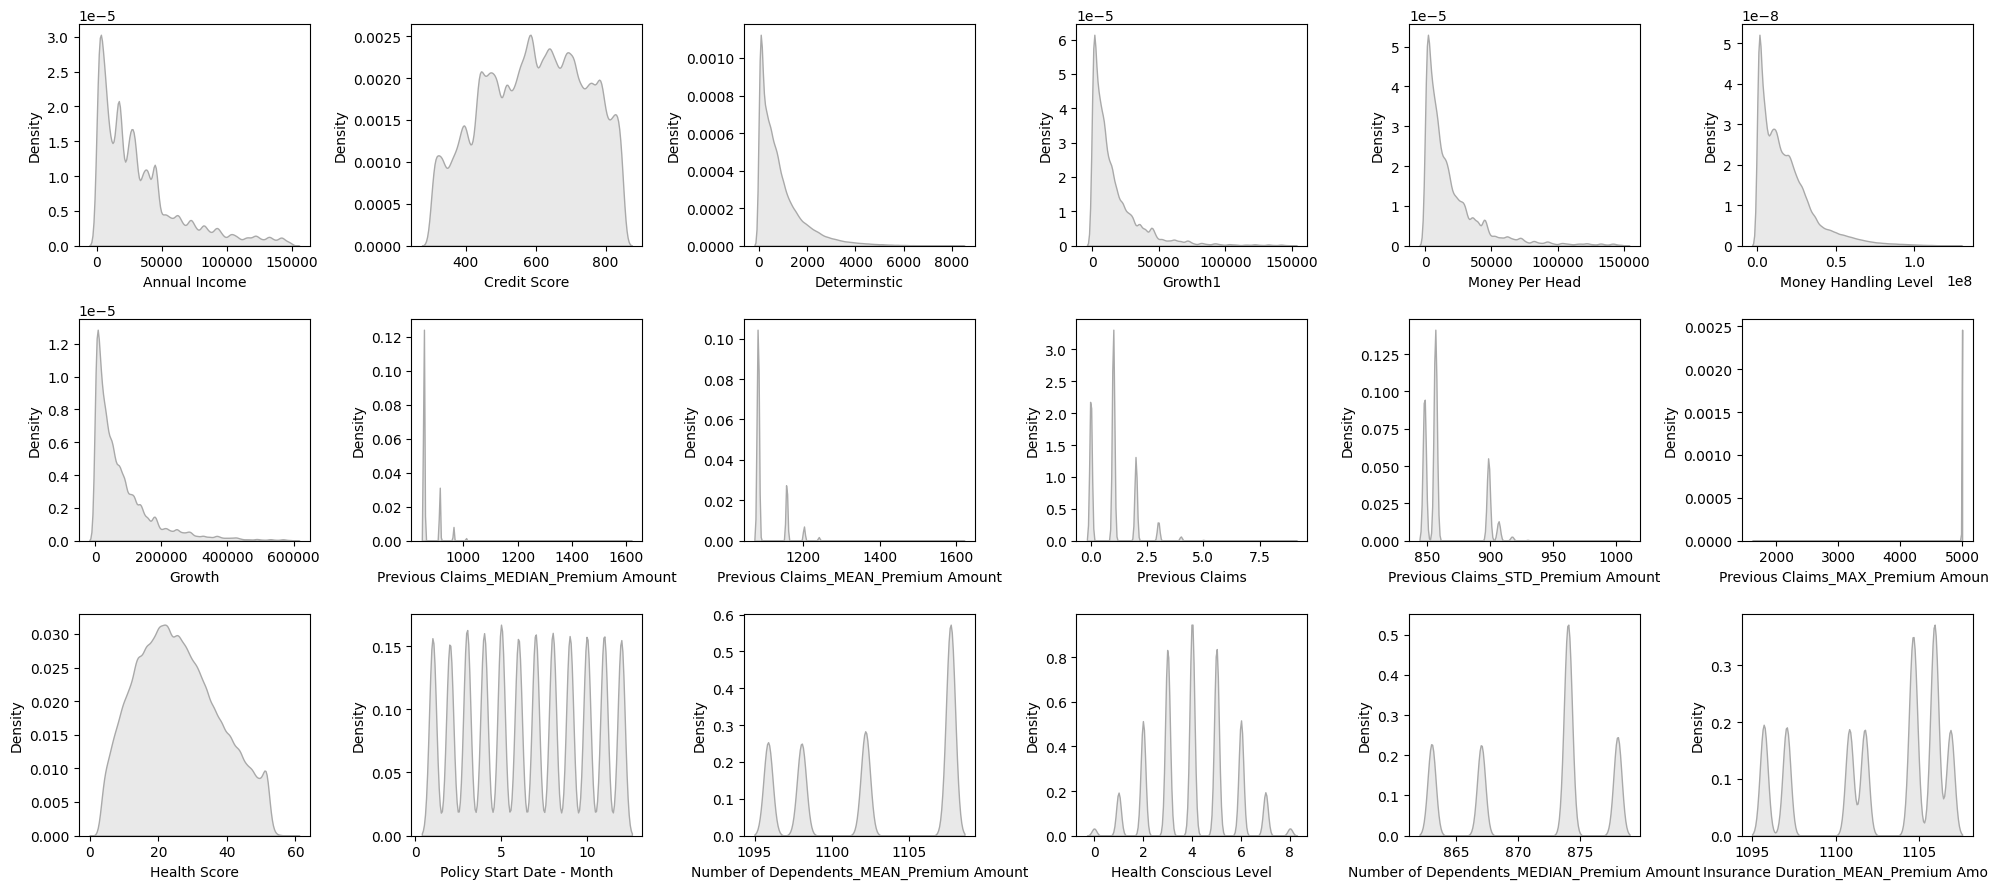

In [76]:
fig, axs = plt.subplots(3, 6, figsize=(20, 9))

for i, ax in zip(x_train.columns, axs.flatten()):
    sns.kdeplot(x_train[i], ax=ax, color="darkgray", fill=True)

plt.tight_layout()
plt.show()

In [77]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [78]:
def do_scaling(scaler):
    var_cols = list(map(lambda x : x.replace(" ", "_"), x_train.columns))
    scalers = {}
    cols = x_train.columns
    
    for i in range(len(cols)):
        scalers[f"SCALER_{var_cols[i]}"] = scaler
        
        x_train[f"SCALER_{var_cols[i]}"] = scalers[f"SCALER_{var_cols[i]}"].fit_transform(x_train[[cols[i]]]).flatten()
        x_train.drop(columns=cols[i], inplace=True)

        x_validate[f"SCALER_{var_cols[i]}"] = scalers[f"SCALER_{var_cols[i]}"].transform(x_validate[[cols[i]]]).flatten()
        x_validate.drop(columns=cols[i], inplace=True)

        test[f"SCALER_{var_cols[i]}"] = scalers[f"SCALER_{var_cols[i]}"].transform(test[[cols[i]]]).flatten()
        test.drop(columns=cols[i], inplace=True)
    
    return scalers

In [79]:
scaler_objects = do_scaling(RobustScaler())
scaler_objects

{'SCALER_Annual_Income': RobustScaler(),
 'SCALER_Credit_Score': RobustScaler(),
 'SCALER_Determinstic': RobustScaler(),
 'SCALER_Growth1': RobustScaler(),
 'SCALER_Money_Per_Head': RobustScaler(),
 'SCALER_Money_Handling_Level': RobustScaler(),
 'SCALER_Growth': RobustScaler(),
 'SCALER_Previous_Claims_MEDIAN_Premium_Amount': RobustScaler(),
 'SCALER_Previous_Claims_MEAN_Premium_Amount': RobustScaler(),
 'SCALER_Previous_Claims': RobustScaler(),
 'SCALER_Previous_Claims_STD_Premium_Amount': RobustScaler(),
 'SCALER_Previous_Claims_MAX_Premium_Amount': RobustScaler(),
 'SCALER_Health_Score': RobustScaler(),
 'SCALER_Policy_Start_Date_-_Month': RobustScaler(),
 'SCALER_Number_of_Dependents_MEAN_Premium_Amount': RobustScaler(),
 'SCALER_Health_Conscious_Level': RobustScaler(),
 'SCALER_Number_of_Dependents_MEDIAN_Premium_Amount': RobustScaler(),
 'SCALER_Insurance_Duration_MEAN_Premium_Amount': RobustScaler(),
 'SCALER_Insurance_Duration_MEDIAN_Premium_Amount': RobustScaler(),
 'SCALER_N

In [80]:
x_train.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Determinstic,SCALER_Growth1,SCALER_Money_Per_Head,SCALER_Money_Handling_Level,SCALER_Growth,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Health_Conscious_Level,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
318241,1.560717,-0.331897,2.213050,0.582188,0.391794,1.367587,2.916654,-1.0,0.000000,0.0,0.000000,0.0,-0.549768,-0.2,-0.655226,-0.5,-1.571429,0.458999,1.50,0.000000,0.000000,0.000000,0.0,0.0,0.333333,-0.521739,-0.783022,1.0,0.872245,-0.133068,-0.996931,0.333333,0.5,0.5,0.0,1.0,0.0,1.0
462313,-0.572650,0.172414,-0.528540,-0.438481,-0.365929,-0.572165,-0.465496,-1.0,0.000000,0.0,0.000000,0.0,0.333343,1.2,-0.429599,0.0,-1.000000,-0.739699,0.00,-0.651740,-0.333333,-0.683947,0.4,0.0,0.222222,0.478261,-2.155882,-1.0,0.000000,0.466755,-0.596501,-1.000000,-0.9,0.0,1.0,0.0,0.0,1.0
532960,1.046749,-1.155172,1.724559,0.325349,0.878950,0.320156,2.118825,28.5,24.535366,1.0,4.862885,-3.0,-0.628021,0.8,0.575111,0.0,0.000000,0.000000,0.25,0.802161,0.000000,0.000000,0.0,0.0,0.555556,-0.608696,0.280920,0.0,0.872245,0.999976,-0.197319,-0.333333,-0.1,-0.5,0.0,1.0,1.0,0.0


In [81]:
x_validate.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Determinstic,SCALER_Growth1,SCALER_Money_Per_Head,SCALER_Money_Handling_Level,SCALER_Growth,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Health_Conscious_Level,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
326819,0.029710,0.275862,0.111914,0.856384,0.615234,0.134315,-0.267003,0.0,-1.000000,-1.0,-1.000000,1.0,0.441425,0.2,-0.429599,0.5,-1.000000,-1.483870,-2.75,-0.651740,-0.333333,-0.683947,0.4,0.0,-0.666667,-0.217391,-0.133238,-1.0,0.000000,-0.599666,0.000512,0.333333,0.6,-0.5,1.0,0.0,1.0,0.0
222326,-0.333224,-0.271552,-0.144983,-0.364248,0.024063,-0.362953,-0.023303,28.5,24.535366,1.0,4.862885,-3.0,-0.768695,0.8,0.570401,-2.0,0.571429,0.260301,1.00,0.726836,0.666667,0.316053,-0.6,0.0,0.000000,-0.608696,0.820980,-0.5,-0.127755,-0.266124,-0.095584,-0.333333,-0.1,0.5,0.0,0.0,0.0,0.0
922979,-0.279785,0.146552,-0.366067,0.237744,0.111109,-0.246987,-0.387110,0.0,-1.000000,-1.0,-1.000000,1.0,0.531328,1.2,-0.429599,0.0,-1.000000,0.458999,1.50,-0.651740,0.000000,0.000000,0.0,0.0,0.333333,0.913043,-0.783022,-1.0,0.872245,-0.666810,-0.799052,0.000000,0.3,0.0,0.0,1.0,0.0,1.0


In [82]:
test.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Determinstic,SCALER_Growth1,SCALER_Money_Per_Head,SCALER_Money_Handling_Level,SCALER_Growth,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Health_Conscious_Level,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
1200000,-0.600448,-0.452586,-0.510061,-0.466263,-0.488269,-0.619532,-0.487072,28.5,24.535366,1.0,4.862885,-3.0,-0.963350,0.0,-0.655226,-1.0,-1.571429,-1.483870,-2.75,0.000000,-0.333333,-0.683947,0.4,0.0,-0.666667,-0.565217,-0.133238,1.0,0.000000,-0.798095,0.903363,0.333333,0.5,-0.5,1.0,0.0,0.0,1.0
1200001,2.777969,-0.974138,3.468356,1.763730,2.288914,1.581509,3.470636,-1.0,0.000000,0.0,0.000000,0.0,-0.639397,-0.4,0.575111,-1.5,0.000000,0.260301,1.00,0.802161,-0.333333,-0.683947,0.4,0.0,0.000000,-0.434783,0.820980,0.0,0.000000,0.400240,0.401327,0.666667,0.9,0.5,1.0,0.0,1.0,0.0
1200002,-0.196800,0.952586,-0.229226,-0.296075,0.246280,-0.000786,0.188468,-1.0,0.000000,0.0,0.000000,0.0,-0.018299,-0.4,-0.429599,-0.5,-1.000000,-1.753579,-2.75,-0.651740,0.000000,0.000000,0.0,0.0,-0.666667,0.260870,-1.066031,-1.0,0.872245,-0.732381,0.605521,0.333333,0.5,0.0,0.0,1.0,0.0,0.0


#
---
#

# Joining All Data

In [83]:
train = pd.concat([pd.concat([x_train, y_train], axis=1), pd.concat([x_validate, y_validate], axis=1)]).sort_index()
train.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Determinstic,SCALER_Growth1,SCALER_Money_Per_Head,SCALER_Money_Handling_Level,SCALER_Growth,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Health_Conscious_Level,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single,Premium Amount
0,-0.389121,-0.974138,-0.064182,-0.255056,-0.066985,-0.494460,-0.323051,28.5,24.535366,1.0,4.862885,-3.0,-0.117678,1.2,0.570401,0.0,0.571429,-0.739699,0.0,0.726836,-0.333333,-0.683947,0.4,0.0,0.222222,-0.956522,-2.155882,-0.5,0.0,0.467739,0.702766,0.333333,0.7,-0.5,1.0,0.0,1.0,0.0,2869.0
1,0.201496,0.413793,0.218852,0.047050,-0.044286,0.383475,0.471049,-1.0,0.000000,0.0,0.000000,0.0,-0.515532,0.0,0.000000,-1.0,0.000000,0.458999,1.5,-0.273164,-0.333333,-0.683947,0.4,0.0,0.333333,-0.086957,-0.783022,0.5,0.0,-0.266203,0.201401,0.333333,0.5,0.0,1.0,0.0,0.0,0.0,1483.0
2,0.035581,-0.185345,0.519379,0.868119,-0.134371,0.009355,-0.264725,-1.0,0.000000,0.0,0.000000,0.0,1.273519,0.6,0.000000,0.0,0.000000,-0.557755,0.0,-0.273164,-0.333333,-0.683947,0.4,0.0,0.333333,-0.782609,0.000000,0.5,0.0,0.933426,0.398433,0.333333,0.6,0.5,1.0,0.0,0.0,0.0,567.0


In [84]:
test.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Determinstic,SCALER_Growth1,SCALER_Money_Per_Head,SCALER_Money_Handling_Level,SCALER_Growth,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Health_Conscious_Level,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
1200000,-0.600448,-0.452586,-0.510061,-0.466263,-0.488269,-0.619532,-0.487072,28.5,24.535366,1.0,4.862885,-3.0,-0.963350,0.0,-0.655226,-1.0,-1.571429,-1.483870,-2.75,0.000000,-0.333333,-0.683947,0.4,0.0,-0.666667,-0.565217,-0.133238,1.0,0.000000,-0.798095,0.903363,0.333333,0.5,-0.5,1.0,0.0,0.0,1.0
1200001,2.777969,-0.974138,3.468356,1.763730,2.288914,1.581509,3.470636,-1.0,0.000000,0.0,0.000000,0.0,-0.639397,-0.4,0.575111,-1.5,0.000000,0.260301,1.00,0.802161,-0.333333,-0.683947,0.4,0.0,0.000000,-0.434783,0.820980,0.0,0.000000,0.400240,0.401327,0.666667,0.9,0.5,1.0,0.0,1.0,0.0
1200002,-0.196800,0.952586,-0.229226,-0.296075,0.246280,-0.000786,0.188468,-1.0,0.000000,0.0,0.000000,0.0,-0.018299,-0.4,-0.429599,-0.5,-1.000000,-1.753579,-2.75,-0.651740,0.000000,0.000000,0.0,0.0,-0.666667,0.260870,-1.066031,-1.0,0.872245,-0.732381,0.605521,0.333333,0.5,0.0,0.0,1.0,0.0,0.0


In [85]:
df = pd.concat([train, test])

#
---
#

# Download the `Model Ready df`

In [86]:
df.to_csv("trainable_df.csv", index=False)